In [1]:
import numpy as np
import kmapper as km
import google.genai.types as types
import google.genai as genai
from typing import List
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

client = genai.Client()

In [2]:
def get_normed_embedding(text, dim, client=client, verbose=False):
    ''' Get a normalized embedding from Gemini for semantic similarity.'''
    result = client.models.embed_content(
        model="gemini-embedding-001",
        contents=text,
        config=types.EmbedContentConfig(
            output_dimensionality=dim,
            task_type="SEMANTIC_SIMILARITY"
        )
    )
    [embedding_obj] = result.embeddings
    if verbose:
        embedding_length = len(embedding_obj.values)
        print(f"Length of embedding: {embedding_length}")
    
    embedding_values_np = np.array(embedding_obj.values)
    normed_embedding = embedding_values_np / np.linalg.norm(embedding_values_np)

    if verbose:
        print(f"Normed embedding length: {len(normed_embedding)}")
        print(f"Norm of normed embedding: {np.linalg.norm(normed_embedding):.6f}") # Should be very close to 1

    return normed_embedding

In [3]:
texts = [
    "What is the meaning of life?",
    "What is the meaning of the universe?",
    "Whats the capital of France?"
]

results = []
for text in texts:
    normed_embedding = get_normed_embedding(text, 768, verbose=True)
    results.append(normed_embedding)

Length of embedding: 768
Normed embedding length: 768
Norm of normed embedding: 1.000000
Length of embedding: 768
Normed embedding length: 768
Norm of normed embedding: 1.000000
Length of embedding: 768
Normed embedding length: 768
Norm of normed embedding: 1.000000


In [4]:
# Check cosine similarities
embeddings_matrix = np.array(results)
similarity_matrix = cosine_similarity(embeddings_matrix)

for i, text1 in enumerate(texts):
    for j in range(i + 1, len(texts)):
        text2 = texts[j]
        similarity = similarity_matrix[i, j]
        print(f"Similarity between '{text1}' and '{text2}': {similarity:.4f}")


Similarity between 'What is the meaning of life?' and 'What is the meaning of the universe?': 0.8642
Similarity between 'What is the meaning of life?' and 'Whats the capital of France?': 0.7399
Similarity between 'What is the meaning of the universe?' and 'Whats the capital of France?': 0.7357


In [5]:
def get_embedding(texts: List[str], dim: int = 3072, client=client) -> np.ndarray:
    ''' Get normalized embeddings from Gemini for semantic similarity.'''
    result = [
        e.values for e in client.models.embed_content(
            model="gemini-embedding-001",
            contents=texts,
            config=types.EmbedContentConfig(
                output_dimensionality=dim,
                task_type="SEMANTIC_SIMILARITY"
            )).embeddings
            ]
    result = np.array(result) ## (N, dim)
    norms = np.linalg.norm(result, axis=1, keepdims=True)  ## (N, 1)
    return result / norms  ## (N, dim)

def get_distance_matrix(input, dim: int = 3072, client=client) -> np.ndarray:
    ''' Get distance matrix between texts using Gemini embeddings.'''
    if isinstance(input, List):
        embeddings = get_embedding(input, dim=dim, client=client)  ## (N, dim)
    elif isinstance(input, np.ndarray):
        embeddings = input  ## (N, dim)
    else:
        raise ValueError("texts must be a List[str] or np.ndarray")
    return cosine_distances(embeddings)  ## (N, N)

In [6]:
texts = [
    "What is the meaning of life?",
    "What is the meaning of the universe?",
    "Whats the capital of France?",
    "What is the airspeed velocity of an unladen swallow?"
]

distance_matrix = get_distance_matrix(texts)
distance_matrix

array([[0.        , 0.12632987, 0.24390213, 0.18698605],
       [0.12632987, 0.        , 0.24588149, 0.22184549],
       [0.24390213, 0.24588149, 0.        , 0.23411016],
       [0.18698605, 0.22184549, 0.23411016, 0.        ]])

Importo el corpus de texto para analizar con mapper

In [24]:
import pandas as pd
data = pd.read_csv('../data/raw/sql-console-for-marianbasti-boletin-oficial-argentina.csv', index_col='id')
data = data.dropna(subset=['full_text'])
data['date'] = pd.to_datetime(data['date'])
data['new_office'] = (data['date'] >= pd.Timestamp('2023-12-10'))
print(data.shape)
data.head(2)

(3650, 5)


,title,name,full_text,date,new_office
id,,,,,
1,DECRETO 617/2025 - MODIFICACION,Decreto 782 / 2025,COMBUSTIBLES Decreto 782/2025 DECTO-2025-782...,2025-10-31,True
2,DECRETO 557/2023 - MODIFICACION,Decreto 781 / 2025,NOMENCLATURA COMÚN DEL MERCOSUR Decreto 781/2...,2025-10-31,True


Text(0.5, 1.0, 'Histogram of Text Lengths')

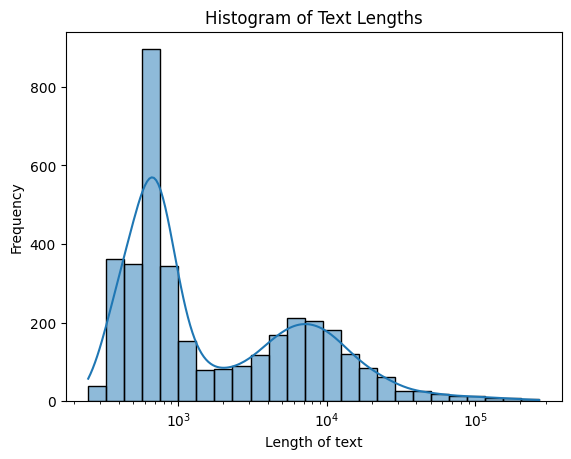

In [8]:
## Histograma de longitudes de los textos
import matplotlib.pyplot as plt
import seaborn as sns
text_lengths = data['full_text'].apply(len)
sns.histplot(text_lengths, kde=True, log_scale=True)
plt.xlabel('Length of text')
plt.ylabel('Frequency')
plt.title('Histogram of Text Lengths')

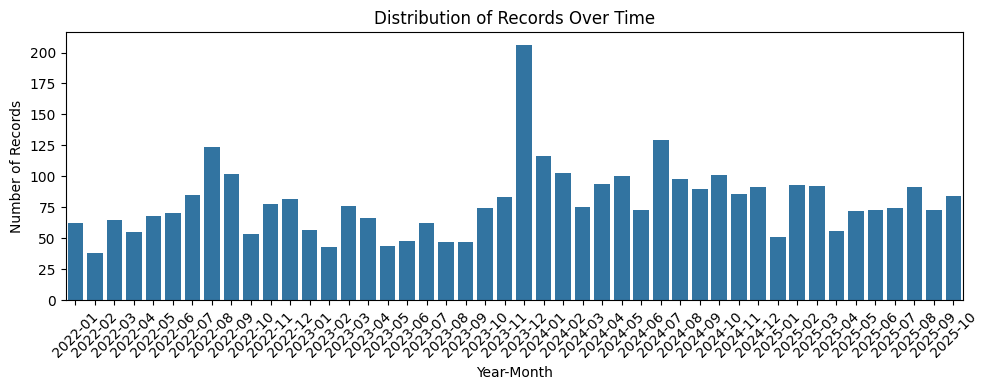

In [9]:
## Distribucion de registros a lo largo del tiempo
data['year_month'] = data['date'].dt.to_period('M')
records_per_month = data.groupby('year_month').size()
plt.figure(figsize=(10, 4))
sns.barplot(x=records_per_month.index.astype(str), y=records_per_month.values)
plt.xlabel('Year-Month')
plt.ylabel('Number of Records')
plt.title('Distribution of Records Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
# Filtrado provisorio
data = data.head(10)

In [11]:
points = get_embedding(data['full_text'].tolist(), dim=3072, client=client)
points.shape

(10, 3072)

In [12]:
distance_matrix = get_distance_matrix(data['full_text'].tolist())
distance_matrix

array([[0.        , 0.13607871, 0.20021162, 0.21146   , 0.21061212,
        0.16788586, 0.21006002, 0.22464765, 0.13775722, 0.17377654],
       [0.13607871, 0.        , 0.23239321, 0.23411659, 0.23015246,
        0.18452893, 0.23232885, 0.23721665, 0.15320658, 0.19131225],
       [0.20021162, 0.23239321, 0.        , 0.05785287, 0.0311209 ,
        0.21350145, 0.05276533, 0.15362029, 0.23954783, 0.24693399],
       [0.21146   , 0.23411659, 0.05785287, 0.        , 0.04846216,
        0.20732373, 0.02372738, 0.14190735, 0.24299911, 0.23950261],
       [0.21061212, 0.23015246, 0.0311209 , 0.04846216, 0.        ,
        0.21092049, 0.04297711, 0.15355314, 0.23765368, 0.23946975],
       [0.16788586, 0.18452893, 0.21350145, 0.20732373, 0.21092049,
        0.        , 0.20611247, 0.20313111, 0.18641802, 0.16238061],
       [0.21006002, 0.23232885, 0.05276533, 0.02372738, 0.04297711,
        0.20611247, 0.        , 0.13885394, 0.24465452, 0.24010272],
       [0.22464765, 0.23721665, 0.1536202

Filtro 1: Primeras 2 dimensiones

In [13]:
def filter_function(texts):
    return get_embedding(texts, dim=2, client=client)

In [14]:
lens = filter_function(data['full_text'].tolist())
lens.shape

(10, 2)

In [15]:
lens

array([[ 0.46868595,  0.88336487],
       [ 0.27122124,  0.96251703],
       [-0.96585905,  0.25906811],
       [-0.90181034,  0.43213204],
       [-0.88367079,  0.46810889],
       [-0.2991797 ,  0.95419678],
       [-0.90108487,  0.43364278],
       [-0.96751035,  0.25283139],
       [-0.16994681,  0.98545324],
       [-0.40796063,  0.91299952]])

In [30]:
df_points = pd.DataFrame(points, index=data.index)
df_points

,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
id,,,,,,,,,,,,,,,,,,,,,
1,0.013251,0.024975,0.012284,-0.062619,0.006680,0.019607,0.009994,-0.006490,0.003264,-0.003797,...,0.000414,0.005244,0.004759,-0.010794,-0.014797,0.005602,-0.000510,-0.012508,-0.018283,-0.004542
2,0.003930,0.013949,0.016150,-0.051602,0.004675,0.019924,0.020731,-0.004217,0.002281,-0.010296,...,0.004121,-0.001970,-0.013304,0.009280,-0.005102,-0.006296,-0.005692,-0.000091,-0.005250,-0.001679
3,-0.015568,0.004176,-0.000592,-0.079834,-0.004610,0.010561,0.013083,0.001919,-0.002450,-0.000370,...,0.018578,0.015666,0.010249,0.002449,-0.002889,0.008718,-0.000404,-0.007255,-0.000936,-0.011706
4,-0.022893,0.010970,0.001084,-0.072414,-0.004603,0.004897,0.021090,0.022323,-0.017881,-0.013088,...,0.011877,0.008144,0.007274,-0.009441,-0.001895,-0.003152,-0.000678,-0.006561,0.006809,-0.012876
5,-0.024753,0.013112,-0.006718,-0.077369,0.006077,0.009584,0.019788,0.015782,-0.006762,-0.003768,...,0.013432,0.012021,0.007722,0.003579,-0.000512,0.008090,-0.002368,-0.010794,0.002273,-0.017428
6,-0.006034,0.019243,0.000529,-0.056191,-0.007652,0.016821,0.019838,-0.000534,0.013222,0.014507,...,0.015248,0.001298,-0.012789,-0.004257,0.002626,0.016587,-0.005365,0.009434,-0.010170,-0.002204
7,-0.019341,0.009308,0.008069,-0.067646,-0.004994,0.005847,0.016326,0.019744,-0.005353,-0.008889,...,0.014475,0.010518,0.005525,-0.002661,0.001440,-0.005286,0.002946,-0.008260,0.009490,-0.008325
8,-0.018891,0.004937,-0.014753,-0.053901,-0.017608,0.001749,0.015144,0.007596,0.016778,0.016399,...,0.028937,0.012840,0.016922,0.011460,0.001616,0.004059,-0.012059,-0.008135,0.008414,-0.012837
9,-0.004618,0.026777,0.008853,-0.067744,0.015519,0.005661,0.016797,0.010189,0.006429,-0.003617,...,0.007230,0.001616,-0.000013,-0.000480,-0.007535,0.004482,-0.002252,-0.003893,-0.007463,-0.003781


In [28]:
df_lens = pd.DataFrame(lens, index=data.index)
df_lens

,0,1
id,,
1,0.468686,0.883365
2,0.271221,0.962517
3,-0.965859,0.259068
4,-0.901810,0.432132
5,-0.883671,0.468109
6,-0.299180,0.954197
7,-0.901085,0.433643
8,-0.967510,0.252831
9,-0.169947,0.985453


In [16]:
from sklearn.cluster import DBSCAN
mapper = km.KeplerMapper(verbose=0)

# Uso la matriz de distancias en lugar de points
graph_z = mapper.map(
    lens,
    distance_matrix, 
    cover=km.Cover(n_cubes=15, perc_overlap=0.3),
    clusterer=DBSCAN(eps=0.3, min_samples=2, metric='precomputed'),
    precomputed=True
)

print(f"Nodos: {len(graph_z['nodes'])}, Enlaces: {len(graph_z['links'])}")


Nodos: 2, Enlaces: 0


In [18]:
mapper.visualize(
    graph_z,
    path_html="../results/mapper_boletin_oficial.html",
    title="Mapper Graph of Boletin Oficial Argentina"
)

'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title>Mapper Graph of Boletin Oficial Argentina | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  width:  85px;\n  height: 85px;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#header {\n  background: #111111;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transform: uppercase;\n}\n\nh4 {\n  fo